### Imports

In [230]:
import os
import numpy as np
import trimesh
import random
import math
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import keras.models

from PIL import Image
from random import seed
from random import random
from sklearn.decomposition import PCA

import keyboard

### Read data

In [17]:
def read_off(file):
    return trimesh.load(file).sample(8192)


def plot3D(data):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(data[:, 0], data[:, 1], data[:, 2])
    ax.view_init(30, 200)


def plot2DBW(data):
    plt.imshow(data[1],'gray')
    plt.show()

In [3]:
categories = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]

train_data = []
test_data = []

path = './ModelNet10/'

current = 0

for category in categories:

    files_train = os.listdir(path + category + "/train")

    for f in files_train:
        train_data.append((category, read_off(path + category + "/train/" + f)))
        current += 1
        if current % 100 == 0:
            print(current)

    files_test = os.listdir(path + category + "/test")

    for f in files_test:
        test_data.append((category, read_off(path + category + "/test/" + f)))
        current += 1
        if current % 100 == 0:
            print(current)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


### Normalize

In [4]:
def normalize(train_data):
    current = 0
    normalizedSize = 240
    new_train_data = []

    maxXReal = 0
    maxYReal = 0
    maxZReal = 0

    for model in train_data:
        minX = 123123123
        minY = 123123123
        minZ = 123123123
        maxX = -123123123
        maxY = -123123123
        maxZ = -123123123

        for point in model[1]:
            minX = min(minX, point[0])
            minY = min(minY, point[1])
            minZ = min(minZ, point[2])
            maxX = max(maxX, point[0])
            maxY = max(maxY, point[1])
            maxZ = max(maxZ, point[2])

        result = []

        if maxX - minX >= maxY - minY and maxX - minX >= maxZ - minZ:
            divRatio = maxX - minX
        elif maxY - minY >= maxX - minX and maxY - minY >= maxZ - minZ:
            divRatio = maxY - minY
        else:
            divRatio = maxZ - minZ

        for point in model[1]:
            newX = ((point[0] - minX) / divRatio) * normalizedSize
            newY = ((point[1] - minY) / divRatio) * normalizedSize
            newZ = ((point[2] - minZ) / (maxZ - minZ)) * normalizedSize

            maxXReal = max(maxXReal, newX)
            maxYReal = max(maxYReal, newY)
            maxZReal = max(maxZReal, newZ)

            result.append(np.array([newX, newY, newZ]))

            # print(str(point[0]) + " + " + str(point[1]) + " + " + str(point[2]))

        new_train_data.append((model[0], np.array(result)))

        current += 1

        if current % 100 == 0:
            print(current)

        # print(str(minX) + " + " + str(maxX))
    return new_train_data

In [5]:
train_data_n = normalize(train_data)
test_data_n = normalize(test_data)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
100
200
300
400
500
600
700
800
900


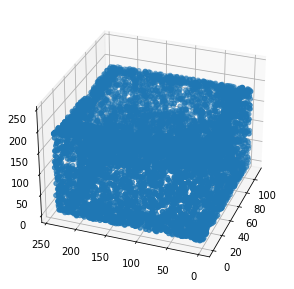

In [193]:
index = 3
plot3D(train_data_n[index][1])

### Process the data ( 2D simple slicing )

In [55]:
def changeView(data):
    current = 0
    normalizedSize = 240
    images = []

    for model in data:
        slices = np.zeros((normalizedSize*4, normalizedSize*4), 'uint8')
        for point in model[1]:
            point_slice = int((point[2] - 0.001) / (normalizedSize / (numberOfImages)))
            i = int(point_slice / 4)
            j = int(point_slice % 4)
            targetI = int(point[0] - 0.01 + i * normalizedSize)
            targetJ = int(point[1] - 0.01 + j * normalizedSize)
            for nextI in range(3):
                for nextJ in range(3):
                    goI = targetI + nextI - 1
                    goJ = targetJ + nextJ - 1

                    if goI < 0 or goI >= 4*normalizedSize or goJ < 0 or goJ >= 4*normalizedSize:
                        continue

                    slices[goI, goJ] = 1
        images.append((model[0], slices))
        current += 1
        if current % 100 == 0:
            print(current)

    return images

In [7]:
train_images = changeView(train_data_n)
test_images = changeView(test_data_n)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
100
200
300
400
500
600
700
800
900


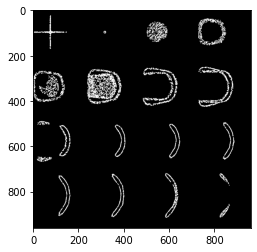

In [404]:
plot2DBW(train_images[850])

### Process the data ( 2D multiaxis slicing )

In [406]:
def changeViewRGB(data):
    current = 0
    normalizedSize = 80
    images = []

    for model in data:
        slices = np.zeros((3, normalizedSize, normalizedSize, 3), 'uint8')
        dividend = int(255/4)
        for point in model[1]:
            point_slice_x = int((point[0] - 0.001) / 20)
            point_slice_y = int((point[1] - 0.001) / 20)
            point_slice_z = int((point[2] - 0.001) / 20)
            i = int(point_slice_x / 4)
            j = int(point_slice_y / 4)
            k = int(point_slice_z / 4)

            goI = int((point[0] - 1 - 0.01)/3)
            goJ = int((point[1] - 1 - 0.01)/3)

            if 0 <= goI < normalizedSize and 0 <= goJ < normalizedSize:
                slices[0, goI, goJ, k] += (255 - slices[0, goI, goJ, k])/2

            goI = int((point[0] - 1 - 0.01)/3)
            goJ = int((point[2] - 1 - 0.01)/3)

            if 0 <= goI < normalizedSize and 0 <= goJ < normalizedSize:
                slices[1, goI, goJ, j] += (255 - slices[1, goI, goJ, j])/2

            goI = int((point[1] - 1 - 0.01)/3)
            goJ = int((point[2] - 1 - 0.01)/3)

            if 0 <= goI < normalizedSize and 0 <= goJ < normalizedSize:
                slices[2, goI, goJ, i] += (255 - slices[2, goI, goJ, i])/2

            #slices[int(point[0] - 0.01), int(point[1] - 0.01), i] |= (3 << (2 * j))


        images.append((model[0], slices))
        current += 1
        if current % 100 == 0:
            print(current)

    return images

In [407]:
train_images_rgb = changeViewRGB(train_data_n)
test_images_rgb = changeViewRGB(test_data_n)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
100
200
300
400
500
600
700
800
900


In [408]:
def combineToSinglePicture(data):
    images = []
    normalizedSize = 80
    padding = int(0)
    for image in data:
        slices = np.zeros((normalizedSize, normalizedSize*3 + padding*2, 3), 'uint8')
        slices[:, 0:normalizedSize,:] = image[1][0,:,:]
        slices[:, normalizedSize + padding:2*normalizedSize + padding,:] = image[1][1,:,:]
        slices[:, 2*normalizedSize + padding*2: 3*normalizedSize + padding*2,:] = image[1][2,:,:]
        images.append((image[0], slices))
    return images

In [409]:
train_images_rgb_combined = combineToSinglePicture(train_images_rgb)
test_images_rgb_combined = combineToSinglePicture(test_images_rgb)

table


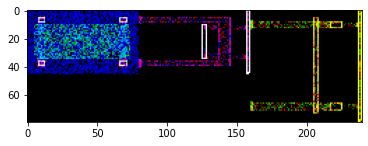

In [429]:
index = 3500
print(train_images_rgb_combined[index][0])
plt.imshow(train_images_rgb_combined[index][1])
plt.show()

### Prepare to feed to the model

In [430]:
train_final = np.array([i[1] for i in train_images_rgb_combined])
train_labels = np.array([categories.index(l) for l in [i[0] for i in train_images_rgb_combined]])

In [431]:
test_final = np.array([i[1] for i in test_images_rgb_combined])
test_labels = np.array([categories.index(l) for l in [i[0] for i in test_images_rgb_combined]])

In [432]:
train_final[0].shape

(80, 240, 3)

### The Model

In [433]:
# model = tf.keras.Sequential([
#     # tf.keras.layers.Conv2D(60, kernel_size=(3, 3), input_shape=(240*4, 240*4, 1)),
#     # tf.keras.layers.MaxPool2D(pool_size=(8, 8)),
#     # tf.keras.layers.Conv2D(60, kernel_size=(3, 3)),
#     # tf.keras.layers.MaxPool2D(pool_size=(8, 8)), # !!! 2 2
#     tf.keras.layers.Flatten(),
#     # tf.keras.layers.Dropout(0.7),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(32, activation='relu'),
#     #tf.keras.layers.Dropout(0.5),
#     #tf.keras.layers.Dense(512, activation='relu'),
#     #tf.keras.layers.Dropout(0.5),
#     #tf.keras.layers.Dense(256, activation='relu'),
#     #tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])
#
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=2, input_shape=(80, 240, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(80, kernel_size=2),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(160, kernel_size=2),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(320, kernel_size=2),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [223]:
test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

29/29 - 4s - loss: 411.7029 - accuracy: 0.7952 - 4s/epoch - 121ms/step

Test accuracy: 0.7951542139053345


In [435]:
model.fit(train_final, train_labels, epochs=6)

test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/6
125/125 [==============================] - 14s 109ms/step - loss: 0.1747 - accuracy: 0.9546
Epoch 2/6
125/125 [==============================] - 14s 109ms/step - loss: 0.1545 - accuracy: 0.9584
Epoch 3/6
125/125 [==============================] - 14s 110ms/step - loss: 0.1512 - accuracy: 0.9637
Epoch 4/6
125/125 [==============================] - 14s 109ms/step - loss: 0.1640 - accuracy: 0.9577
Epoch 5/6
125/125 [==============================] - 14s 109ms/step - loss: 0.1021 - accuracy: 0.9742
Epoch 6/6
125/125 [==============================] - 14s 109ms/step - loss: 0.0760 - accuracy: 0.9832
29/29 - 1s - loss: 0.8184 - accuracy: 0.8502 - 1s/epoch - 41ms/step

Test accuracy: 0.850220263004303


#### Step by step fit

In [441]:
import time

def current_milli_time():
    return round(time.time() * 1000)

current_time = current_milli_time()

In [ ]:
i = 12
while current_milli_time() - current_time <= 10 * 60 * 1000:
    i += 1
    print(i)
    print(train_final.shape, train_labels.shape)
    model.fit(train_final, train_labels, epochs=1)
    test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)
    print('Test accuracy:', test_acc, '\n')

13
(3991, 80, 240, 3) (3991,)
125/125 [==============================] - 14s 109ms/step - loss: 0.5517 - accuracy: 0.9246
29/29 - 1s - loss: 1.2841 - accuracy: 0.8568 - 1s/epoch - 41ms/step
Test accuracy: 0.8568282127380371 

14
(3991, 80, 240, 3) (3991,)
125/125 [==============================] - 14s 110ms/step - loss: 0.4918 - accuracy: 0.9196
29/29 - 1s - loss: 1.1156 - accuracy: 0.8238 - 1s/epoch - 41ms/step
Test accuracy: 0.8237885236740112 

15
(3991, 80, 240, 3) (3991,)
125/125 [==============================] - 14s 109ms/step - loss: 0.4217 - accuracy: 0.9323
29/29 - 1s - loss: 0.8262 - accuracy: 0.8447 - 1s/epoch - 42ms/step
Test accuracy: 0.8447136282920837 

16
(3991, 80, 240, 3) (3991,)
125/125 [==============================] - 14s 110ms/step - loss: 0.1276 - accuracy: 0.9672
29/29 - 1s - loss: 1.0874 - accuracy: 0.8645 - 1s/epoch - 40ms/step
Test accuracy: 0.8645374178886414 

17
(3991, 80, 240, 3) (3991,)
125/125 [==============================] - 14s 108ms/step - loss: 

In [440]:
test_loss, test_acc = model.evaluate(test_final, test_labels, verbose=2)
print('Test accuracy:', test_acc, '\n')

29/29 - 1s - loss: 1.1418 - accuracy: 0.8921 - 1s/epoch - 41ms/step
Test accuracy: 0.892070472240448 



#### Save the model

In [442]:
modelID = "892AccWtf"
model.save(modelID + ".h5")
np.save(modelID + '_train_final.npy', train_final)
np.save(modelID + '_test_final.npy', test_final)
np.save(modelID + '_train_labels.npy', train_labels)
np.save(modelID + '_test_labels.npy', test_labels)

#### Load the model

In [ ]:
modelID = "randomNeuralNetwork"
model = keras.models.load_model(modelID + ".h5")
train_final = np.load(modelID + '_train_final.npy')
test_final = np.load(modelID + '_test_final.npy')
train_labels = np.load(modelID + '_train_labels.npy')
test_labels = np.load(modelID + '_test_labels.npy')